In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/audiofile/sample-6s.wav


In [2]:
import torch
import numpy as np
import soundfile as sf
import librosa
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error
from scipy.io.wavfile import write
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
audio_path = '/kaggle/input/audiofile/sample-6s.wav' 
audio, sr = librosa.load(audio_path, sr=22050, duration=5)  

# Normalize audio
audio = audio / np.max(np.abs(audio))

In [6]:
# Create time points corresponding to the audio signal
t = np.linspace(0, len(audio) / sr, len(audio)).reshape(-1, 1) 

# Amplitudes are the audio signal values
A = audio.reshape(-1, 1)  

# Convert to torch tensors
X = torch.tensor(t, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')
Y = torch.tensor(A, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X_np = X.cpu().numpy()
    X_transformed = rff.fit_transform(X_np)
    return torch.tensor(X_transformed, dtype=torch.float32).to(X.device)

# Generate RFF features
num_features = 1500 
X_rff = create_rff_features(X, num_features, sigma=0.005)


In [8]:
class SimpleLinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleLinearModel, self).__init__()
        self.fc1 = nn.Linear(in_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = SimpleLinearModel(X_rff.shape[1], 1).to(X.device)


In [9]:
def train(model, X, Y, lr=0.001, epochs=3000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

# Train the model
train(model, X_rff, Y, lr=0.001, epochs=3000)


Epoch 0, Loss: 0.019482
Epoch 500, Loss: 0.003270
Epoch 1000, Loss: 0.002767
Epoch 1500, Loss: 0.002493
Epoch 2000, Loss: 0.002305
Epoch 2500, Loss: 0.002315


SimpleLinearModel(
  (fc1): Linear(in_features=1500, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [9]:
def reconstruct_audio(model, X):
    model.eval()
    with torch.no_grad():
        reconstructed_audio = model(X).cpu().numpy()
    return reconstructed_audio

# Reconstruct the audio
reconstructed_audio = reconstruct_audio(model, X_rff).flatten()


In [10]:
# RMSE
rmse = np.sqrt(mean_squared_error(audio, reconstructed_audio))
print(f"RMSE: {rmse:.6f}")

# SNR calculation
def snr(original, reconstructed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - reconstructed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

snr_value = snr(audio, reconstructed_audio)
print(f"SNR: {snr_value:.6f} dB")


RMSE: 0.045402
SNR: 9.778795 dB


In [11]:
# Save original and reconstructed audio for playback
write("original_audio.wav", sr, audio)
write("reconstructed_audio.wav", sr, reconstructed_audio)


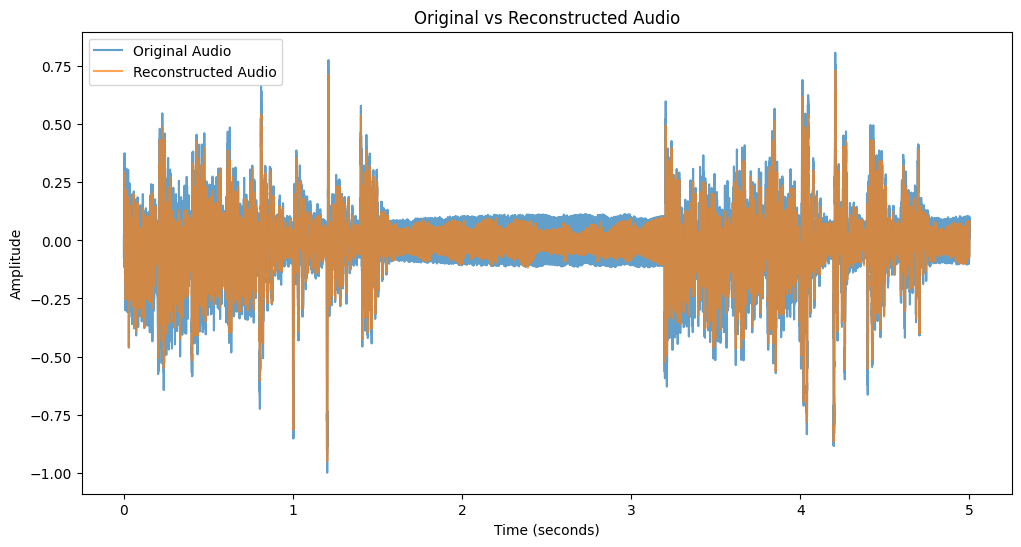

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(t, audio, label='Original Audio', alpha=0.7)
plt.plot(t, reconstructed_audio, label='Reconstructed Audio', alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio')
plt.legend()
plt.show()


In [13]:
from IPython.display import Audio, display
import soundfile as sf

# Save audio files
sf.write("original_audio.wav", audio, sr)
sf.write("reconstructed_audio.wav", reconstructed_audio, sr)

# Display and play the audio files in the notebook
print("Original Audio:")
display(Audio("original_audio.wav"))

print("Reconstructed Audio:")
display(Audio("reconstructed_audio.wav"))


Original Audio:


Reconstructed Audio:
